In [3]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import concurrent.futures
from tqdm import tqdm

08013, Boulder (Colorado)<br>
56013, Fremont(Wyoming)<br>
04015, Mohave (Arizona)<br>
32003, Clark (Nevada)<br>
48031, Blanco (Texas)<br>
12099, Palm Beach (Florida)<br>
06081, San Mateo (California)<br>
41011, Coos (Oregon)<br>
04025, Yavapai (Arizona)<br>
36061, New York (New York)<br>
51003, Albermarle (Virginia)<br>
27027, Clay (Minnesota)<br>

In [2]:
county_mapping = {
    'Mohave': '4015', 'Boulder': '8013', 'Fremont': '56013',
    'Clark': '32003', 'Blanco': '48031', 'Palm Beach': '12099',
    'San Mateo': '6081', 'Coos': '41011', 'Yavapai': '4025',
    'New York': '36061', 'Albermarle': '51003', 'Clay': '27027'
}

In [12]:
# Household Files

directory_path = 'explainableAI_clustering'
files = os.path.join(directory_path, '*.csv')
csv_files = glob.glob(files)


dfs = []


for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)


demo_df = pd.concat(dfs, ignore_index=True)


In [13]:
demo_df.shape

(3039301, 19)

In [6]:
u_r_map = pd.read_csv('urban_rural_map.csv')

In [7]:
u_r_map = u_r_map.drop_duplicates().reset_index(drop=True)
u_r_map

,tract_fips,UATYPE
0,4019005200,C
1,4021002101,C
2,4013082023,U
3,4013082019,U
4,4013082020,U
...,...,...
23508,32003005612,C
23509,32023960404,C
23510,32007951401,C
23511,32013010701,C


In [8]:
u_r_df = pd.merge(demo_df,u_r_map, left_on='census_tract_11fips', right_on='tract_fips', how='inner')

In [9]:
u_r_df.head()


,hid,SERIALNO,rid,census_tract_11fips,DIVISION,REGION,ST,NP,BLD,HINCP,...,YBL,RELP,SEX,AGEP,RAC1P,SCH,SCHG,ESR,tract_fips,UATYPE
0,560139405001,17465,13022,56013940500,8,4,56,1,9,0.0,...,6.0,0,1,20,1,1.0,NaN,6.0,56013940500,C
1,560139405002,618700,11220,56013940500,8,4,56,1,4,5000.0,...,6.0,0,2,22,1,2.0,15.0,1.0,56013940500,C
2,560139405003,489449,15517,56013940500,8,4,56,1,4,5000.0,...,5.0,0,1,19,1,2.0,15.0,3.0,56013940500,C
3,560139405004,1052126,15158,56013940500,8,4,56,1,4,20.0,...,5.0,0,2,29,1,2.0,15.0,6.0,56013940500,C
4,560139405005,1154665,13325,56013940500,8,4,56,1,5,7200.0,...,5.0,0,1,33,1,1.0,NaN,1.0,56013940500,C


In [8]:
df_cz = pd.read_csv('explainableAI_clustering/climate_zones/county-climatezone.csv')

In [16]:
#Importing Energy Files

directory_path = 'energy_data'
files = os.path.join(directory_path, '*.csv')
csv_files = glob.glob(files)

energy_dfs = []

for file in csv_files:
    e_df = pd.read_csv(file)
    
    # Performing 5% sampling from each county
    sampled_df = e_df.sample(frac=0.05)
    energy_dfs.append(sampled_df)

In [17]:
combined_df = pd.concat(energy_dfs, ignore_index=True)

In [18]:
columns_to_keep = [f'total_kwh_{i}' for i in range(1, 25)]
columns_to_keep.append('hid')

In [19]:
df = combined_df.drop(columns=[col for col in combined_df.columns if col not in columns_to_keep])
df.head()

,hid,total_kwh_1,total_kwh_2,total_kwh_3,total_kwh_4,total_kwh_5,total_kwh_6,total_kwh_7,total_kwh_8,total_kwh_9,...,total_kwh_15,total_kwh_16,total_kwh_17,total_kwh_18,total_kwh_19,total_kwh_20,total_kwh_21,total_kwh_22,total_kwh_23,total_kwh_24
0,480319502001946,0.106,0.110,0.105,0.100,0.144,2.859,2.815,1.194,0.129,...,0.104,0.104,0.994,0.100,0.424,0.269,0.320,0.524,0.107,0.097
1,480319502002041,0.110,0.112,0.098,0.127,0.124,0.122,0.181,1.037,0.202,...,0.107,0.112,0.497,1.440,0.575,1.012,1.293,1.562,0.111,0.111
2,480319502002233,0.302,0.302,0.164,0.136,0.919,0.129,1.290,1.026,0.241,...,0.109,0.103,0.106,1.199,1.556,0.153,1.108,0.562,0.297,0.470
3,480319501002143,0.132,0.127,0.126,0.133,0.147,0.138,0.189,0.368,0.418,...,0.125,0.251,0.403,0.206,0.262,0.196,0.157,0.291,0.373,0.125
4,48031950100831,0.100,0.106,0.106,0.109,0.113,0.647,0.120,0.179,0.177,...,0.996,0.769,0.107,0.100,0.762,0.690,0.102,0.903,0.560,0.103


In [18]:
df.shape

(911676, 25)

In [21]:
df.to_csv('sampled_energy_data.csv', index=False)

In [2]:
df = pd.read_csv('sampled_energy_data.csv')

In [19]:
df.head()

,hid,total_kwh_1,total_kwh_2,total_kwh_3,total_kwh_4,total_kwh_5,total_kwh_6,total_kwh_7,total_kwh_8,total_kwh_9,...,total_kwh_15,total_kwh_16,total_kwh_17,total_kwh_18,total_kwh_19,total_kwh_20,total_kwh_21,total_kwh_22,total_kwh_23,total_kwh_24
0,480319502001946,0.106,0.110,0.105,0.100,0.144,2.859,2.815,1.194,0.129,...,0.104,0.104,0.994,0.100,0.424,0.269,0.320,0.524,0.107,0.097
1,480319502002041,0.110,0.112,0.098,0.127,0.124,0.122,0.181,1.037,0.202,...,0.107,0.112,0.497,1.440,0.575,1.012,1.293,1.562,0.111,0.111
2,480319502002233,0.302,0.302,0.164,0.136,0.919,0.129,1.290,1.026,0.241,...,0.109,0.103,0.106,1.199,1.556,0.153,1.108,0.562,0.297,0.470
3,480319501002143,0.132,0.127,0.126,0.133,0.147,0.138,0.189,0.368,0.418,...,0.125,0.251,0.403,0.206,0.262,0.196,0.157,0.291,0.373,0.125
4,48031950100831,0.100,0.106,0.106,0.109,0.113,0.647,0.120,0.179,0.177,...,0.996,0.769,0.107,0.100,0.762,0.690,0.102,0.903,0.560,0.103


In [3]:
df.shape

(911676, 25)

In [25]:
# Household count for each county
df['hid'] = df['hid'].astype(str)
county_counts = {county: (df['hid'].str.startswith(code)).sum() for county, code in county_mapping.items()}


for county, count in county_counts.items():
    print(f"{county} = {count}")

Mohave = 32514
Boulder = 37728
Fremont = 5250
Clark = 243828
Blanco = 1572
Palm Beach = 197112
San Mateo = 81012
Coos = 9144
Yavapai = 32472
New York = 251646
Albermarle = 12402
Clay = 6996


In [16]:
# Total count
total_count = sum(county_counts.values())

print(f"Total = {total_count}")

Total = 911676


In [4]:
row_max_values = df.iloc[:, 1:].max(axis=1) # Find the maximum value for each row 

max_norm_df = df.iloc[:, 1:].div(row_max_values, axis=0) # Divide each value by its corresponding max value
max_norm_df = max_norm_df.replace([np.inf, -np.inf, np.nan], 0)

In [27]:
row_avg_values = df.iloc[:, 1:].mean(axis=1)  # Find the average value for each row (axis=1)

avg_norm_df = df.iloc[:, 1:].div(row_avg_values, axis=0)  # Divide each value by its corresponding average value
avg_norm_df = avg_norm_df.replace([np.inf, -np.inf, np.nan], 0)

In [5]:
hourly_usage_max = max_norm_df.iloc[:, 0:24].values
# hourly_usage_avg = avg_norm_df.iloc[:, 0:24].values

In [64]:
# Apply K-Means clustering

wcss = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(hourly_usage_max)
    wcss.append(kmeans.inertia_)

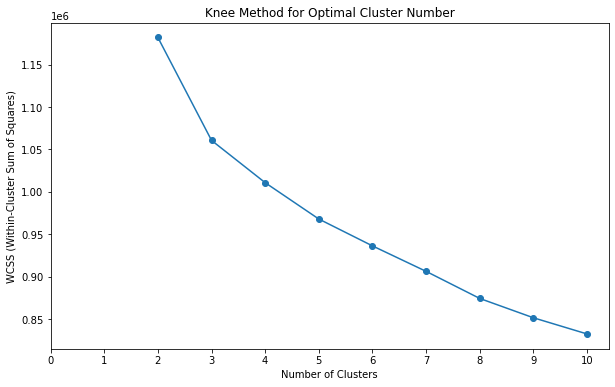

In [65]:
# Plot the WCSS values against the number of clusters

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Knee Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(0, 11))
plt.show()

In [66]:
# Apply K-Means clustering

wcss = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(hourly_usage_avg)
    wcss.append(kmeans.inertia_)

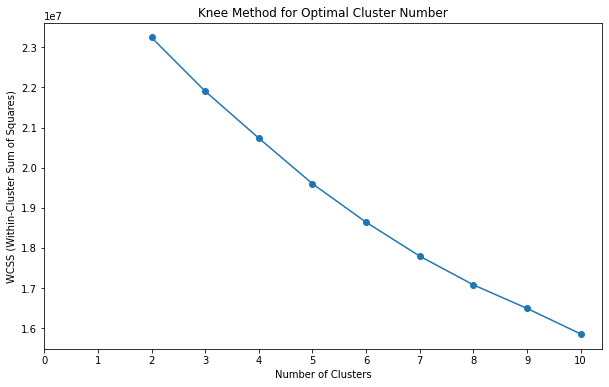

In [68]:
# Plot the WCSS values against the number of clusters

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Knee Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(0, 11))
plt.show()

In [6]:
def kmeans_analysis(df, norm_data, n):
    
    kmeans = KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(norm_data)
    
    df['cluster'] = cluster_labels
    print(df['cluster'].value_counts())
    
    cluster_centers = kmeans.cluster_centers_
    
    # Create a time array for the x-axis (24 hours)
    hours = np.arange(24)
    
    plt.figure(figsize=(10, 6))

    # Plot each cluster's time series curve
    for i, center in enumerate(cluster_centers):
        plt.plot(hours, center, label=f'Cluster {i}')

    plt.xticks(hours)  
    plt.xlabel('Hour')
    plt.ylabel('Value')
    plt.title('Cluster Center')
    plt.legend()
    plt.show()
    
    return df

2    467288
1    347518
0     96870
Name: cluster, dtype: int64


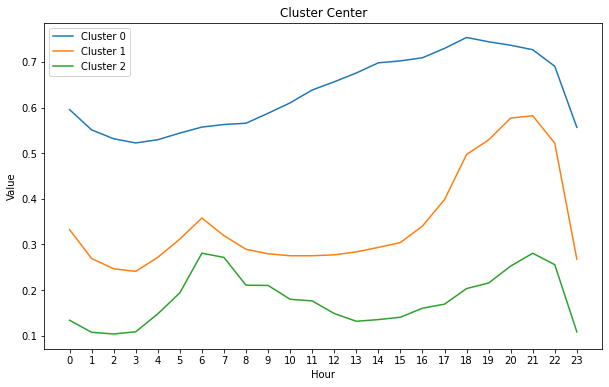

In [7]:
df = kmeans_analysis(df,hourly_usage_max,3)

In [58]:
df['hid'] = df['hid'].astype('int64')

In [59]:
merged_df = pd.merge(df, demo_df, on='hid', how='inner')

In [60]:
merged_df.head()

,hid,total_kwh_1,total_kwh_2,total_kwh_3,total_kwh_4,total_kwh_5,total_kwh_6,total_kwh_7,total_kwh_8,total_kwh_9,...,HINCP,RMSP,YBL,RELP,SEX,AGEP,RAC1P,SCH,SCHG,ESR
0,480319502001946,0.106,0.110,0.105,0.100,0.144,2.859,2.815,1.194,0.129,...,36900.0,8.0,6.0,0,2,33,1,1.0,NaN,1.0
1,480319502002041,0.110,0.112,0.098,0.127,0.124,0.122,0.181,1.037,0.202,...,60500.0,7.0,3.0,0,1,57,1,1.0,NaN,1.0
2,480319502002233,0.302,0.302,0.164,0.136,0.919,0.129,1.290,1.026,0.241,...,25000.0,4.0,1.0,0,1,51,1,1.0,NaN,1.0
3,480319501002143,0.132,0.127,0.126,0.133,0.147,0.138,0.189,0.368,0.418,...,126000.0,5.0,6.0,0,2,49,1,1.0,NaN,1.0
4,480319501002143,0.891,0.934,0.978,1.034,1.058,1.080,5.671,1.620,1.308,...,126000.0,5.0,6.0,0,2,49,1,1.0,NaN,1.0


In [61]:
merged_df.shape

(911676, 44)

In [62]:
state_climate_zone_mapping = {
    '8': 'Cold',      # Colorado
    '56': 'Cold',      # Wyoming
    '4': 'Hot-Dry',   # Arizona
    '32': 'Hot-Dry',   # Nevada
    '48': 'Hot-Humid', # Texas
    '12': 'Hot-Humid', # Florida
    '6': 'Marine',    # California
    '41': 'Marine',    # Oregon
    '2': 'Mixed-Dry', # Arizona
    '36': 'Mixed-Humid', # New York
    '51': 'Mixed-Humid', # Virginia
    '27': 'Very Cold'  # Minnesota
}

In [36]:
demo_df.shape

(3039301, 19)

In [37]:
df.shape

(911676, 26)

In [30]:
df_recs = pd.read_csv("recs2015_public_v2.csv")

In [31]:
columns_to_keep = ['DOEID', 'TOTSQFT_EN', 'KOWNRENT']
df_recs = df_recs[columns_to_keep]

In [63]:
merged_df = pd.merge(df_recs, merged_df, left_on='DOEID', right_on='rid', how='inner')

In [64]:
merged_df.shape

(911676, 47)

In [65]:
merged_df['CZ'] = merged_df['ST'].astype(str).map(state_climate_zone_mapping)

In [66]:
merged_df['CZ'].unique()

array(['Marine', 'Hot-Humid', 'Very Cold', 'Mixed-Humid', 'Cold',
       'Hot-Dry'], dtype=object)

In [67]:
h_counts = merged_df['CZ'].value_counts()


print(h_counts)

Hot-Dry        308814
Mixed-Humid    264048
Hot-Humid      198684
Marine          90156
Cold            42978
Very Cold        6996
Name: CZ, dtype: int64


In [1]:
merged_df.to_csv('merged_sampled_energy_data',index=False)

NameError: name 'merged_df' is not defined

In [4]:
merged_df = pd.read_csv('merged_sampled_energy_data')

In [5]:
sqft_intervals = [228, 1500, 3500,10000]

merged_df['SQFT_TAG'] = pd.cut(merged_df['TOTSQFT_EN'], bins=sqft_intervals, labels=['small', 'medium', 'large'], right=False)
h_counts = merged_df['SQFT_TAG'].value_counts()


print(h_counts)

small     491838
medium    329606
large      90232
Name: SQFT_TAG, dtype: int64


In [6]:
rmsp_intervals = [1,5,9,26]  

merged_df['RMSP_TAG'] = pd.cut(merged_df['RMSP'], bins=rmsp_intervals, labels=['1-4', '5-8', '9+'], right=False)
unit_counts = merged_df['RMSP_TAG'].value_counts()


print(unit_counts)

5-8    506757
1-4    319615
9+      85304
Name: RMSP_TAG, dtype: int64


In [7]:
ybl_intervals = [1,4,6,8,float('inf')]  

merged_df['YBL_TAG'] = pd.cut(merged_df['YBL'], bins=ybl_intervals, labels=['1959 or earlier','1960-1979','1980-1999','2000-2013'], right=False)
unit_counts = merged_df['YBL_TAG'].value_counts()


print(unit_counts)

1980-1999          282767
1959 or earlier    227806
1960-1979          220314
2000-2013          180789
Name: YBL_TAG, dtype: int64


In [8]:
hincp_intervals = [float('-inf'),40000,100000,160000,float('inf')]  

merged_df['HINCP_TAG'] = pd.cut(merged_df['HINCP'], bins=hincp_intervals, labels=['Low income', 'Middle income', 'Upper-middle income','High income'], right=False)
unit_counts = merged_df['HINCP_TAG'].value_counts()


print(unit_counts)

Middle income          329759
Low income             324642
Upper-middle income    138934
High income            118341
Name: HINCP_TAG, dtype: int64


In [9]:
unit_intervals = [0,2,3,4,10,float('inf')]  

merged_df['BLD_TAG'] = pd.cut(merged_df['BLD'], bins=unit_intervals, labels=['Mobile Home/Trailer', 'One-family house A', 'One-family house D','Apts','Mobile Home/Trailer'], right=False, ordered=False)
unit_counts = merged_df['BLD_TAG'].value_counts()


print(unit_counts)

One-family house A     511678
Apts                   300779
One-family house D      52497
Mobile Home/Trailer     46722
Name: BLD_TAG, dtype: int64


In [10]:
person_intervals = [1,2,3, float('inf')]  

merged_df['NP_TAG'] = pd.cut(merged_df['NP'], bins=person_intervals, labels=['1','2', '2+'], right=False)
per_counts = merged_df['NP_TAG'].value_counts()


print(per_counts)

1     317619
2     309864
2+    284193
Name: NP_TAG, dtype: int64


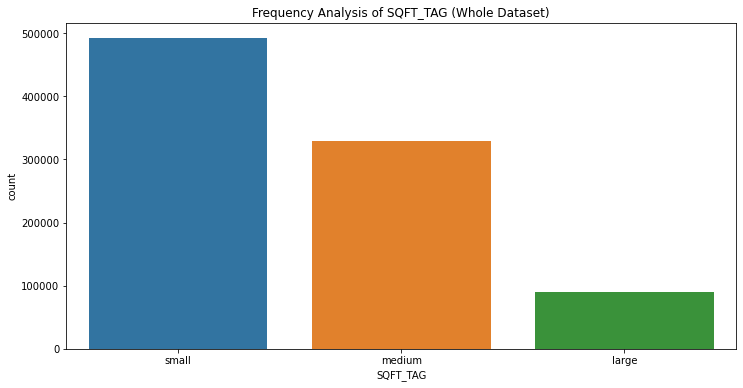

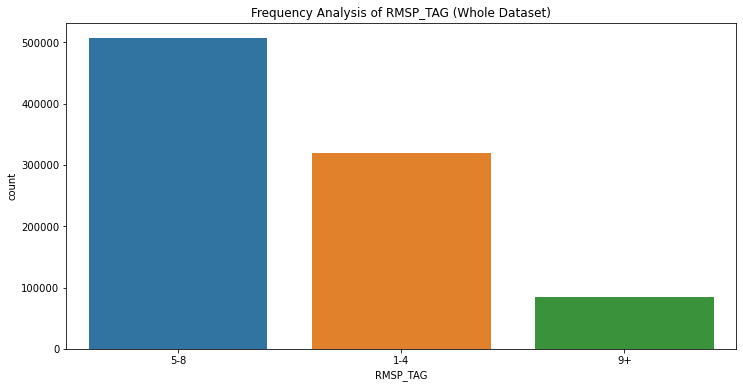

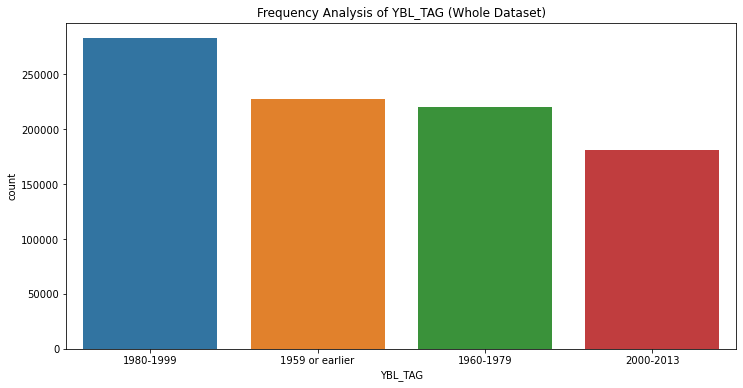

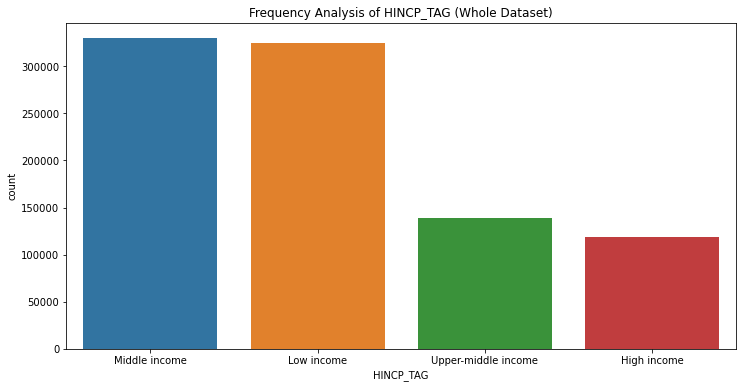

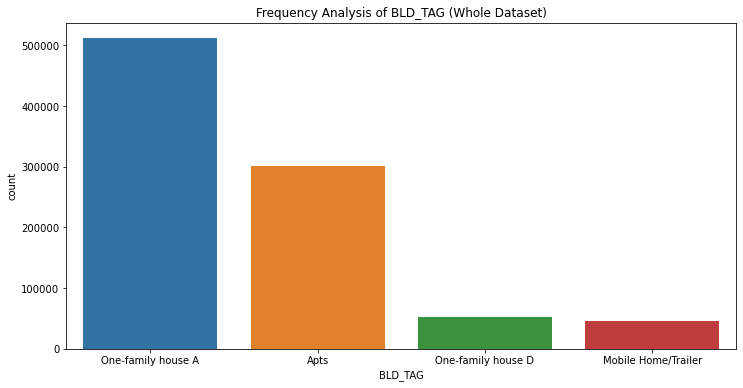

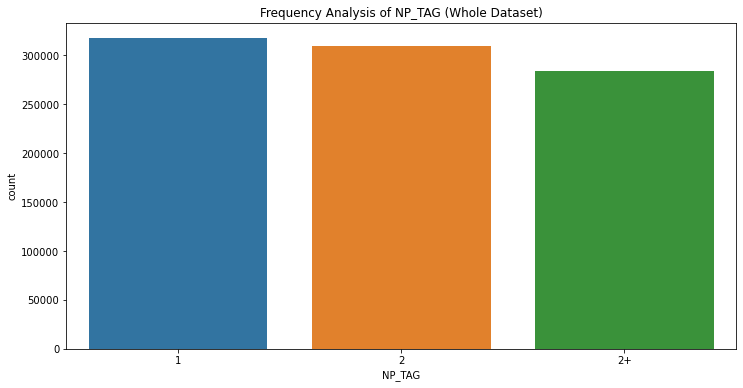

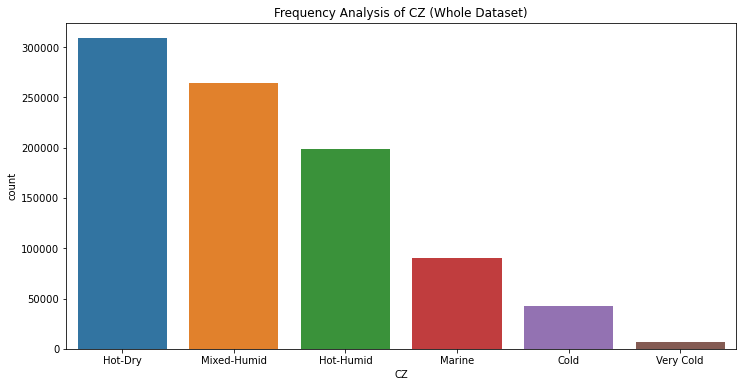

In [12]:
cols = ['SQFT_TAG','RMSP_TAG','YBL_TAG','HINCP_TAG','BLD_TAG','NP_TAG','CZ']

for col in cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=merged_df, x=col, order=merged_df[col].value_counts().index)
    plt.title(f'Frequency Analysis of {col} (Whole Dataset)')
    plt.show()

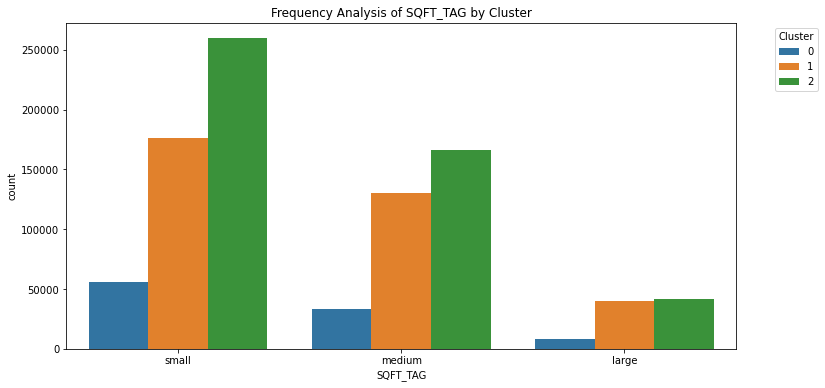

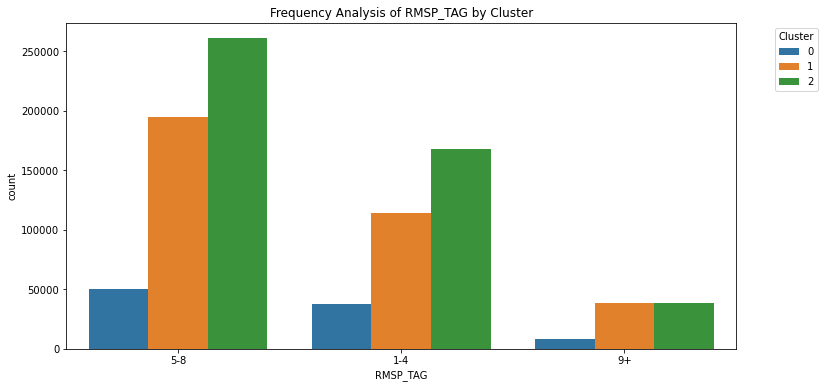

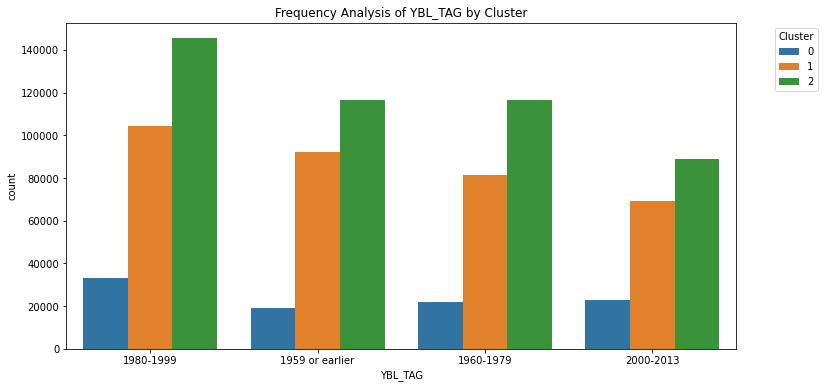

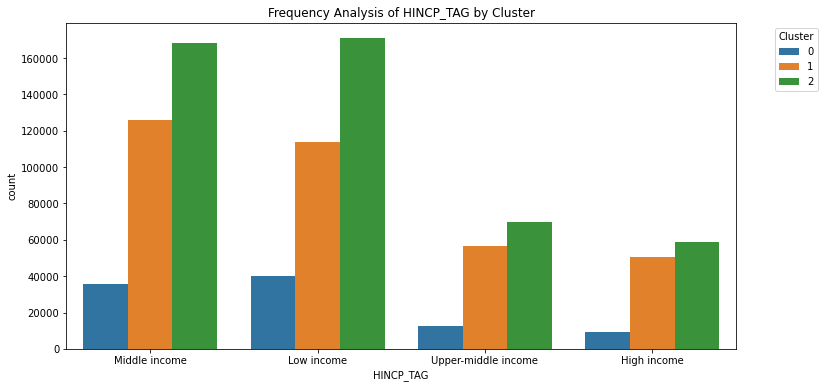

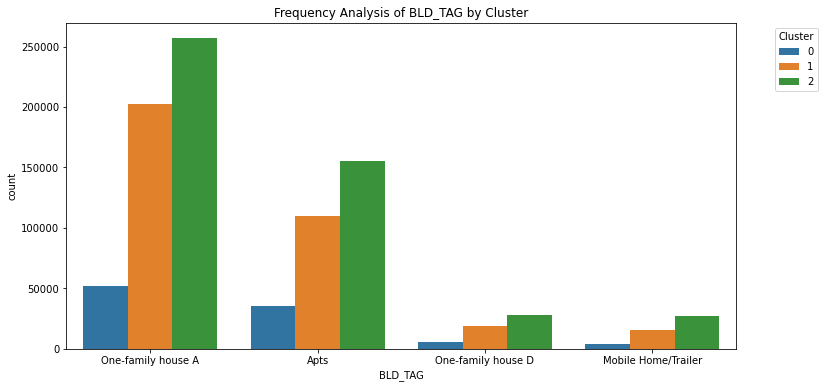

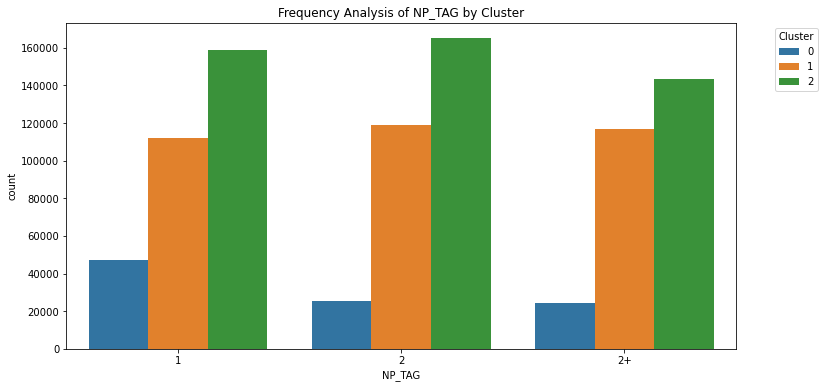

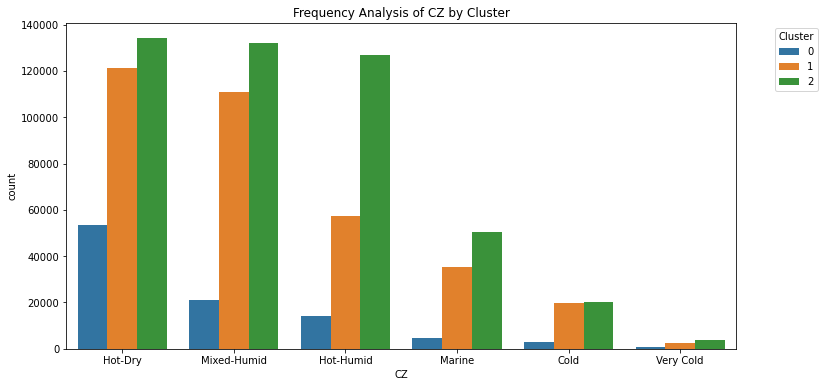

In [13]:
for col in cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=merged_df, x=col, hue='cluster', order=merged_df[col].value_counts().index)
    plt.title(f'Frequency Analysis of {col} by Cluster')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [18]:
import seaborn as sns
import os

# ... (your existing code)

# Create a directory to save the plots
output_directory = 'output_plots'
os.makedirs(output_directory, exist_ok=True)

# Loop through columns and create and save pie charts
for col in cols:
    unique_values = merged_df[col].unique()
    count = 0

    # Create subplots for each unique value in the column
    for val in unique_values:
        plt.figure(figsize=(6, 6))
        count = count + 1
        # Filter data for the current unique value
        subset_df = merged_df[merged_df[col] == val]

        # Count the occurrences of each cluster
        cluster_counts = subset_df['cluster'].value_counts()

        # Plot pie chart
        plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title(f'Cluster Distribution for {col} = {val}')

        # Save the plot
        plot_filename = f'{output_directory}/cluster_distribution_{col}_{count}.png'
        plt.savefig(plot_filename)
        plt.close()  # Close the plot to avoid displaying it

# Optionally, display a message indicating that plots are saved
print(f'All plots saved in {output_directory}')


All plots saved in output_plots


In [71]:
def format_to_input_file(df, alpha, beta, tag_categories,filename):
    
    n = len(df)
    K = df['cluster'].nunique()
    tag_cat_map = []
    unique_tags = []
    tag_type = 0
    
    for category in tag_categories:
        
        tags = df[category].unique() # get all unique tags in a particular category
        
        for tag in tags:
            unique_tags.append(tag) # add it to the main unique tags list
            tag_cat_map.append(tag_type) # add its type to the category map
            
        tag_type = tag_type+1
        
    N = len(unique_tags)
    print("n=",n)
    print("K=",K)
    print("N=",N)
    print(unique_tags)
    print(tag_cat_map)
    
    count = 0

    with open(filename, 'w') as file:
        file.write(f"{n} {K} {N} {alpha} {beta}\n")
        
        # Write the data items
        for index, row in df.iterrows():
            cluster_number = row['cluster']
            tag_set = [1 if str(tag) in row[tag_categories].values else 0 for tag in unique_tags]

            # Write the line for each data item
            file.write(f"{index + 1} {cluster_number} {' '.join(map(str, tag_set))}\n")
            count = count+1
            
            if count%10000 == 0:
                print("checkpoint:",count)

In [70]:

format_to_input_file(merged_df, alpha=2, beta=0, tag_categories=tag_categories,filename='tagged_data_test_2_c3.txt')

n= 911676
K= 3
N= 27
27
27


In [50]:
# Function to format data item in parallel
def write_data_item(args):
    index, row, unique_tags, tag_categories = args
    cluster_number = row['cluster']
    tag_set = [1 if str(tag) in row[tag_categories].values else 0 for tag in unique_tags]
    return f"{index + 1} {cluster_number} {' '.join(map(str, tag_set))}\n"


def format_to_input_file_parallel(df, alpha, beta, tag_categories, filename):
    n = len(df)
    K = df['cluster'].nunique()
    tag_cat_map = []
    unique_tags = []
    tag_type = 0
    
    for category in tag_categories:
        tags = df[category].unique()
        for tag in tags:
            unique_tags.append(tag)
            tag_cat_map.append(tag_type)
        tag_type += 1
        
    N = len(unique_tags)
    
    print("n=", n)
    print("K=", K)
    print("N=", N)
    print(unique_tags)
    print(tag_cat_map)
    count = 0
    
    with open(filename, 'w') as file:
        file.write(f"{n} {K} {N} {alpha} {beta}\n")
        file.write(" ".join(map(str, tag_cat_map)))
        
        # Use a process pool for parallel execution
        with concurrent.futures.ProcessPoolExecutor() as executor:
            args_list = [(index, row, unique_tags, tag_categories) for index, row in df.iterrows()]
            print(len(args_list))
            lines = list(executor.map(write_data_item, args_list, chunksize=10000))
            file.writelines(lines)

In [48]:
tag_categories = ['SQFT_TAG','RMSP_TAG','YBL_TAG','HINCP_TAG','BLD_TAG','NP_TAG','CZ']

In [20]:
merged_df.head()

,DOEID,TOTSQFT_EN,KOWNRENT,hid,total_kwh_1,total_kwh_2,total_kwh_3,total_kwh_4,total_kwh_5,total_kwh_6,...,SCH,SCHG,ESR,CZ,SQFT_TAG,RMSP_TAG,YBL_TAG,HINCP_TAG,BLD_TAG,NP_TAG
0,10001,1808,1,6081605100598,0.115,0.117,0.126,0.123,0.114,0.121,...,3.0,15.0,1.0,Marine,medium,5-8,1959 or earlier,Low income,One-family house A,2
1,10001,1808,1,6081601800662,0.113,0.115,0.115,0.108,0.112,0.106,...,1.0,NaN,1.0,Marine,medium,5-8,1959 or earlier,Middle income,One-family house A,2
2,10001,1808,1,60816024001499,0.596,0.469,0.275,0.155,0.331,0.229,...,1.0,NaN,1.0,Marine,medium,5-8,1960-1979,High income,One-family house A,2
3,10001,1808,1,6081602800548,0.369,0.365,0.363,0.368,0.153,0.520,...,1.0,NaN,1.0,Marine,medium,5-8,1959 or earlier,Middle income,One-family house A,2
4,10001,1808,1,6081602800548,0.257,0.129,0.295,0.153,0.262,3.459,...,1.0,NaN,1.0,Marine,medium,5-8,1959 or earlier,Middle income,One-family house A,2


In [76]:
format_to_input_file_parallel(merged_df, alpha=2, beta=0, tag_categories=tag_categories,filename='tagged_data_test_2_c10.txt')

n= 911676
K= 10
N= 27
['medium', 'small', 'large', '5-8', '9+', '1-4', '1959 or earlier', '1960-1979', '1980-1999', '2000-2013', 'Low income', 'Middle income', 'High income', 'Upper-middle income', 'One-family house A', 'One-family house D', 'Mobile Home/Trailer', 'Apts', '2', '2+', '1', 'Marine', 'Hot-Humid', 'Very Cold', 'Mixed-Humid', 'Cold', 'Hot-Dry']
[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6]
911676
